 Title:
Demand Forecasting for E-Commerce
 
 
 Project Statement:
In the realm of E-Commerce, demand forecasting plays a pivotal role in ensuring business success. This project aims to develop a demand forecasting model in an E-commerce business that predicts future product demand leveraging time series analysis and multivariate regression based on historical sales data, along with Google Analytics KPIs such as Google clicks and Facebook impressions, which are valuable indicators of customer interest.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **Data merging and Exploratory data analysis**




In [3]:
# Load datasets
sales_data = pd.read_excel('ProductA.xlsx')
google_clicks = pd.read_excel('ProductA_google_clicks.xlsx')
facebook_impressions = pd.read_excel('ProductA_fb_impressions.xlsx')

# Convert date fields to datetime
sales_data['Day Index'] = pd.to_datetime(sales_data['Day Index'])
google_clicks['Day Index'] = pd.to_datetime(google_clicks['Day Index'])
facebook_impressions['Day Index'] = pd.to_datetime(facebook_impressions['Day Index'])

# Merge datasets on 'Date'
merged_data = sales_data.merge(google_clicks, on='Day Index', how='left')
merged_data = merged_data.merge(facebook_impressions, on='Day Index', how='left')

# Display the merged dataset
print(merged_data)

     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]


In [4]:
merged_data.shape

(212, 4)

In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [6]:
merged_data.describe()

,Day Index,Quantity,Clicks,Impressions
count,212,212.000000,212.00000,212.000000
mean,2022-03-16 12:00:00,17.542453,358.20283,1531.702830
min,2021-12-01 00:00:00,5.000000,60.00000,620.000000
25%,2022-01-22 18:00:00,13.750000,154.00000,1209.750000
50%,2022-03-16 12:00:00,17.000000,402.50000,1460.000000
75%,2022-05-08 06:00:00,21.000000,492.75000,1862.000000
max,2022-06-30 00:00:00,38.000000,726.00000,2707.000000
std,NaN,5.790423,164.52160,440.660783


In [7]:
# Check for missing values
print("Missing values before handling:")
print(merged_data.isnull().sum())


Missing values before handling:
Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64


In [8]:
merged_data.drop_duplicates()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


# **Outliers detection and imputation**

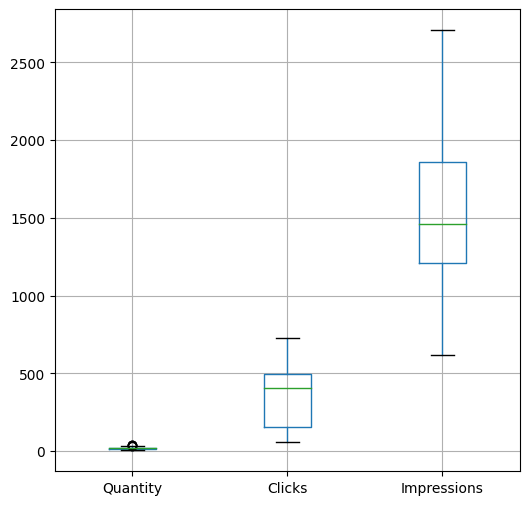

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
merged_data.boxplot()
plt.show()

In [10]:
def identify_outliers_iqr(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  outliers = data[(data < lower_bound) | (data > upper_bound)]
  return outliers

sales_outliers_iqr = identify_outliers_iqr(merged_data['Quantity'])
google_clicks_outliers_iqr = identify_outliers_iqr(merged_data['Clicks'])
facebook_impressions_outliers_iqr = identify_outliers_iqr(merged_data['Impressions'])

print("Sales outliers:", len(sales_outliers_iqr))
print("Google Clicks outliers:", len(google_clicks_outliers_iqr))
print("Facebook Impressions outliers:", len(facebook_impressions_outliers_iqr))


Sales outliers: 5
Google Clicks outliers: 0
Facebook Impressions outliers: 0


In [11]:
print("Sales outliers:\n\n", sales_outliers_iqr)

Sales outliers:

 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


In [12]:
data = merged_data.copy()
print(data)

     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]


In [13]:
# Function to replace outliers with 95th percentile
def replace_outliers_with_percentile(data, percentile=95):
    threshold = data.quantile(percentile / 100)
    data_no_outliers = data.copy()
    data_no_outliers[data > threshold] = threshold
    return data_no_outliers

data['Quantity_no_outliers'] = replace_outliers_with_percentile(data['Quantity']).astype(int)
print(f"Sales outliers after replacement: {len(identify_outliers_iqr(data['Quantity_no_outliers']))}")
print(data.head())

Sales outliers after replacement: 0
   Day Index  Quantity  Clicks  Impressions  Quantity_no_outliers
0 2021-12-01        14     445          620                    14
1 2021-12-02        10     433          890                    10
2 2021-12-03        13     424          851                    13
3 2021-12-04        22     427          881                    22
4 2021-12-05        33     451          678                    27


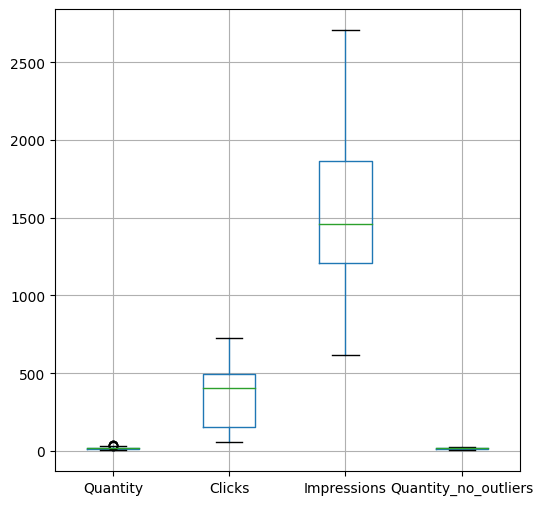

In [14]:
plt.figure(figsize=(6,6))
data.boxplot()
plt.show()

# **Feature Engineering**

In [15]:
# Day of the month
data['Day of the Month'] = data['Day Index'].dt.day# Extract month and day of the week

data['month'] = data['Day Index'].dt.month_name()
data['day_of_week'] = data['Day Index'].dt.day_name()

# Create binary columns for months
months = data['month'].unique()
for month in months:
    data[month] = (data['month'] == month).astype(int)

# Create binary columns for days of the week
days_of_week = data['day_of_week'].unique()
for day in days_of_week:
    data[day] = (data['day_of_week'] == day).astype(int)

# Weekend feature
data['Is_Weekend'] = data['Day Index'].dt.dayofweek.isin([5, 6]).astype(int)

# Weekdays
data['Is_Weekday'] = 1 - data['Is_Weekend']

# Holiday feature
us_holidays = holidays.US()
data['Is_Holiday'] = data['Day Index'].apply(lambda x: 1 if x in us_holidays else 0)

# Week and Month Numeric value
data['day_of_week_num'] = data['Day Index'].dt.dayofweek
data['month_num'] = data['Day Index'].dt.month

print(data.head())

   Day Index  Quantity  Clicks  Impressions  Quantity_no_outliers  \
0 2021-12-01        14     445          620                    14   
1 2021-12-02        10     433          890                    10   
2 2021-12-03        13     424          851                    13   
3 2021-12-04        22     427          881                    22   
4 2021-12-05        33     451          678                    27   

   Day of the Month     month day_of_week  December  January  ...  Friday  \
0                 1  December   Wednesday         1        0  ...       0   
1                 2  December    Thursday         1        0  ...       0   
2                 3  December      Friday         1        0  ...       1   
3                 4  December    Saturday         1        0  ...       0   
4                 5  December      Sunday         1        0  ...       0   

   Saturday  Sunday  Monday  Tuesday  Is_Weekend  Is_Weekday  Is_Holiday  \
0         0       0       0        0          

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Day Index             212 non-null    datetime64[ns]
 1   Quantity              212 non-null    int64         
 2   Clicks                212 non-null    int64         
 3   Impressions           212 non-null    int64         
 4   Quantity_no_outliers  212 non-null    int64         
 5   Day of the Month      212 non-null    int32         
 6   month                 212 non-null    object        
 7   day_of_week           212 non-null    object        
 8   December              212 non-null    int64         
 9   January               212 non-null    int64         
 10  February              212 non-null    int64         
 11  March                 212 non-null    int64         
 12  April                 212 non-null    int64         
 13  May                 

In [17]:
data.to_excel('data_final.xlsx', index=False)

In [18]:
df = pd.read_excel('data_final.xlsx')

# **Visualization**

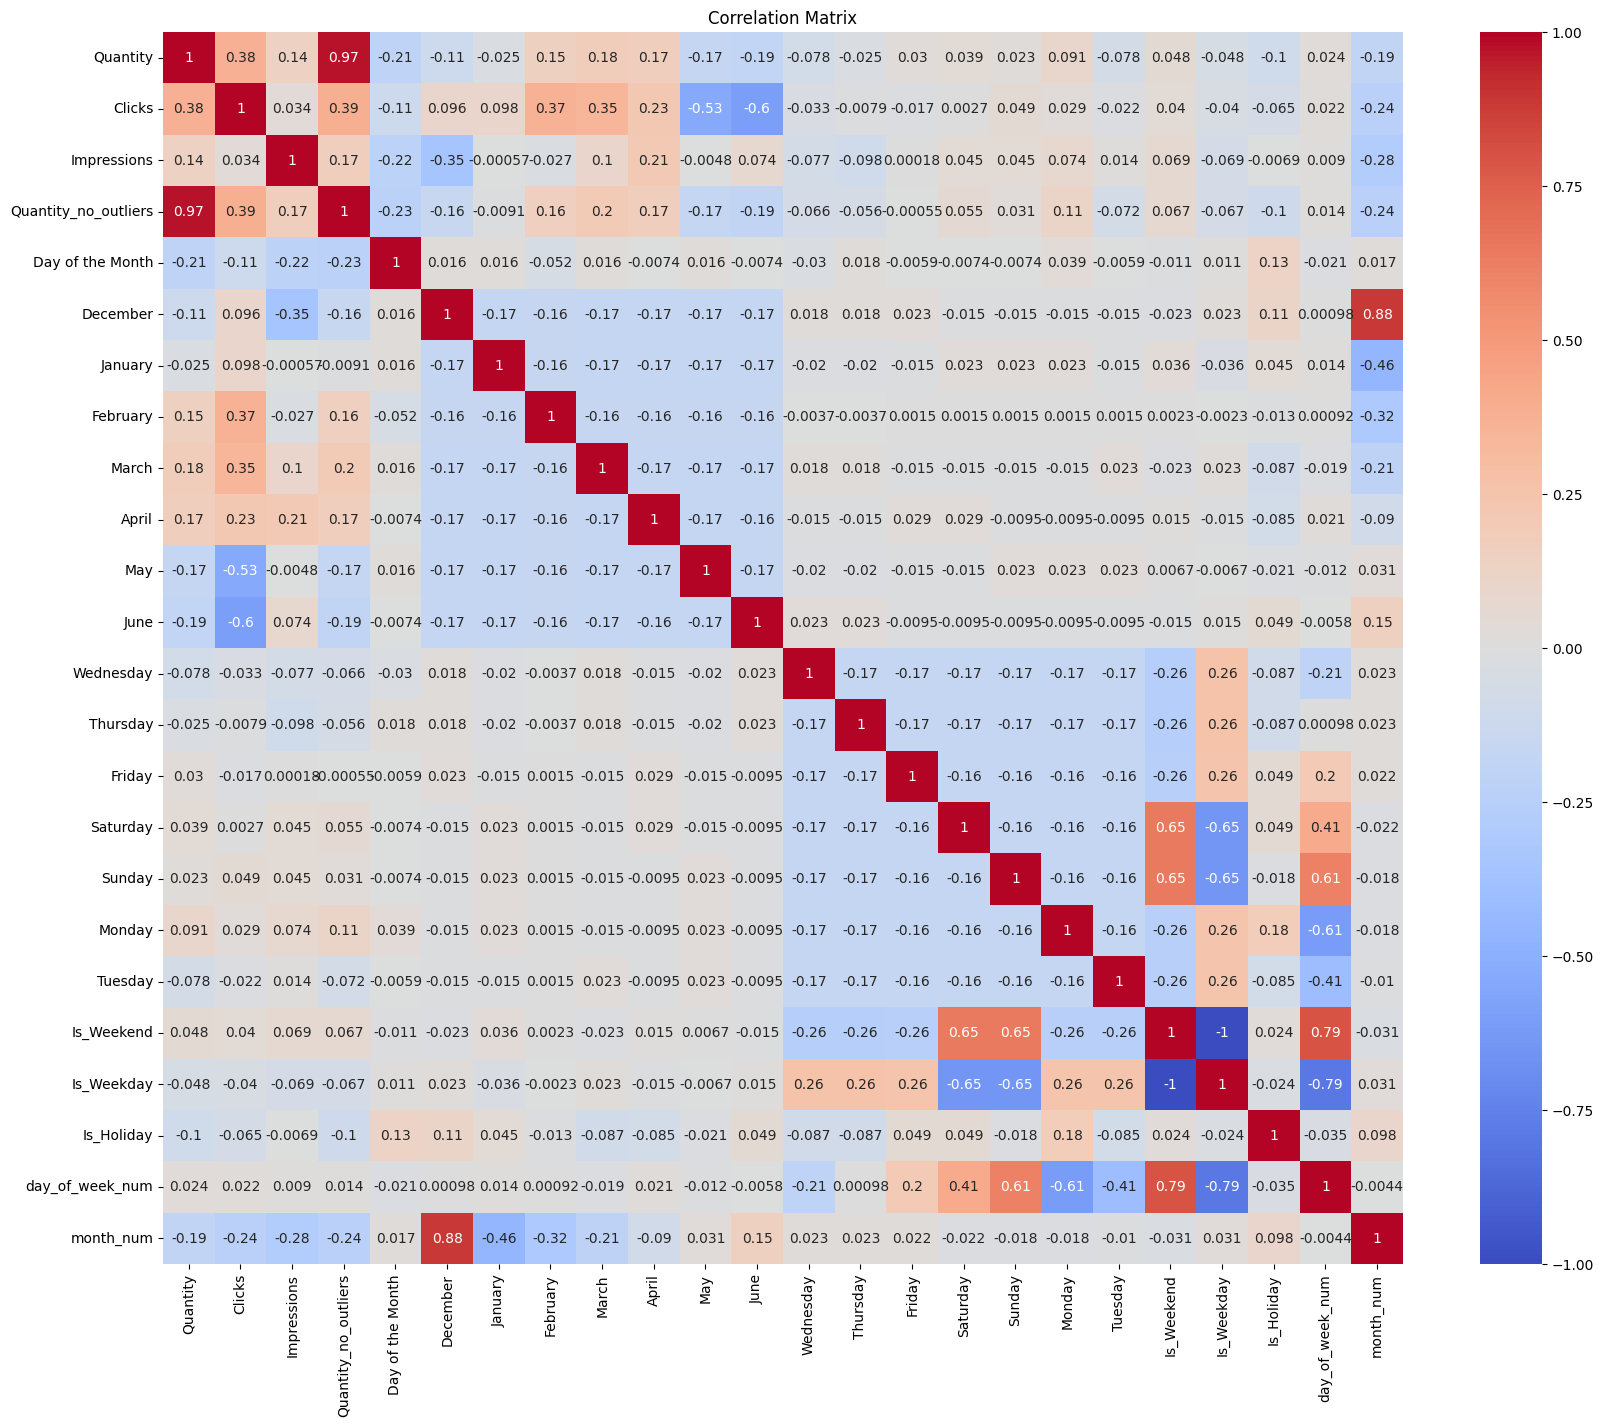

In [19]:
#Coorelation matrix

df_numeric = data.drop(columns=['Day Index', 'day_of_week', 'month'])

plt.figure(figsize=(20,16))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# Set the style of the visualizations
sns.set(style="whitegrid")

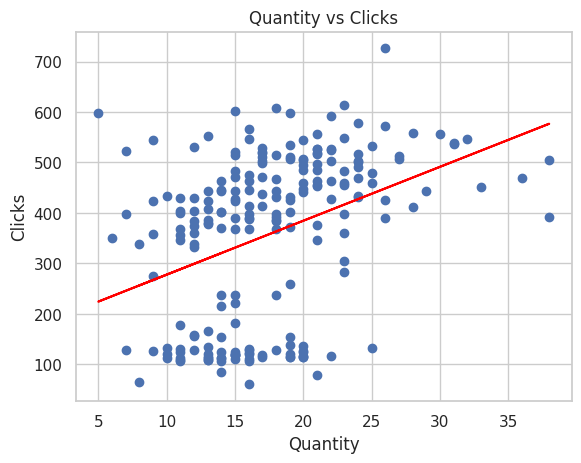

Slope: 10.684347244567512


In [21]:
# Clicks Effect on Quantity

x = df['Quantity'].values.reshape(-1, 1)
y = df['Clicks'].values

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

y_pred = model.predict(x)

# Plot the data and the regression line
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel('Quantity')
plt.ylabel('Clicks')
plt.title('Quantity vs Clicks')
plt.show()

slope = model.coef_[0]

print("Slope:", slope)

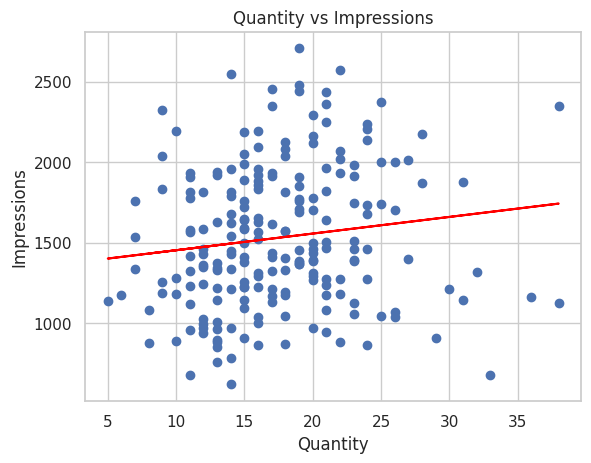

Slope: 10.345459685468713


In [22]:
# Impressions Effect on Quantity
x = df['Quantity'].values.reshape(-1, 1)
y = df['Impressions'].values

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

y_pred = model.predict(x)

# Plot the data and the regression line
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel('Quantity')
plt.ylabel('Impressions')
plt.title('Quantity vs Impressions')
plt.show()

slope = model.coef_[0]

print("Slope:", slope)


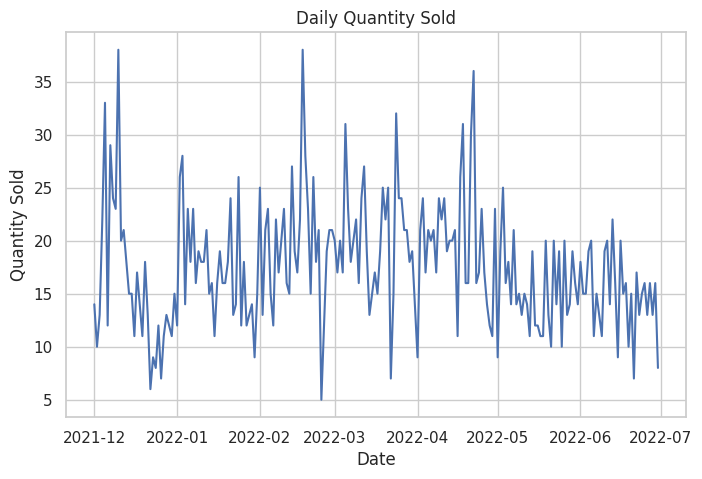

In [23]:
# Daily Quantity Sold
plt.figure(figsize=(8,5))
plt.plot(df['Day Index'], df['Quantity'])
plt.title('Daily Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()


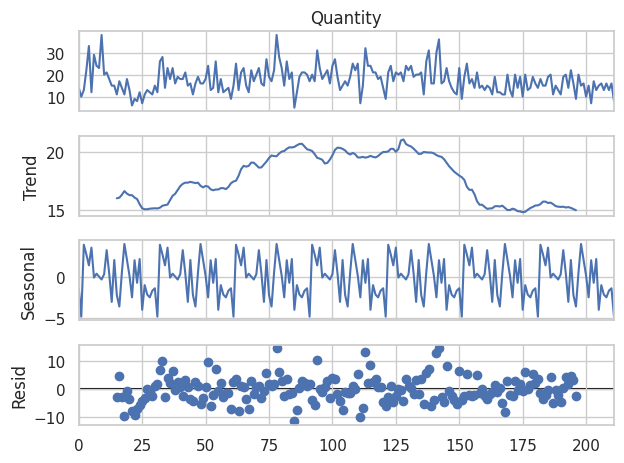

In [24]:
# Seasonality Test
decomposition = seasonal_decompose(df['Quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

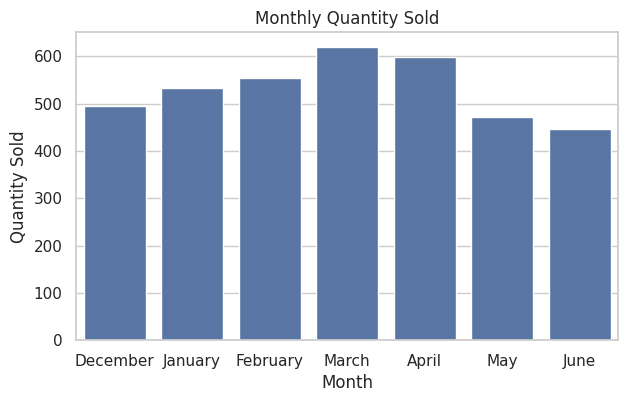

In [25]:
# Monthly Quantity Sold
monthly_quantity = df.groupby('month')['Quantity'].sum().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='month', y='Quantity', data=monthly_quantity, order=['December','January', 'February', 'March', 'April', 'May', 'June'])
plt.title('Monthly Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.show()


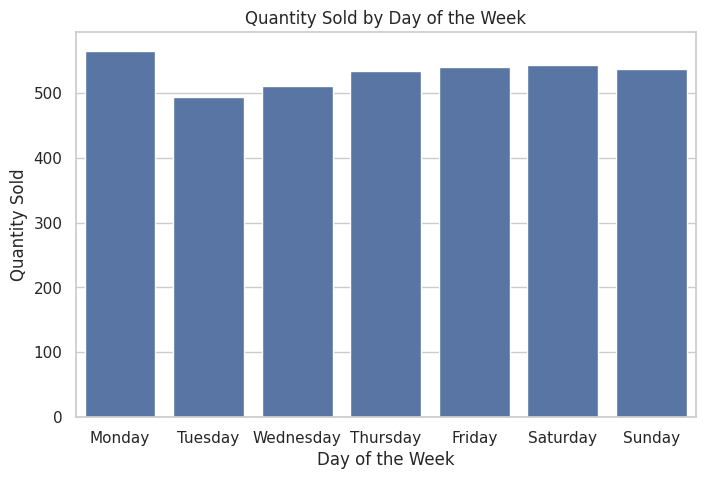

In [26]:
# Quantity Sold by Day of the Week
day_of_week_quantity = df.groupby('day_of_week')['Quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='Quantity', data=day_of_week_quantity, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Quantity Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Quantity Sold')
plt.show()


# **Analysis Report**

Values close to 1 indicate a strong positive correlation. Values close to -1 indicate a strong negative correlation. Values close to 0 indicate little to no correlation.

<> There is a strong positive correlation (0.38) between Quantity and Clicks. This means that as the quantity increases, the number of clicks also tends to increase.

<> Impressions also have slight relation to Quantity.

<> There seem to be recurring patterns or cycles in the sales data, which indicates seasonality.

<> March month  has the highest and June has the lowest sold quantity.

<> Monday has the highest and Tuesday has the lowest sale.


# **Time Series Analysis**


**Stationarity Test(Augmented Dickey–Fuller Test)**

In [27]:
# ADF Test for Sales Quantity
adf_result = adfuller(df['Quantity'])
print('ADF Statistic for Quantity:', adf_result[0].round(3))
print('p-value:', adf_result[1].round(4))

# Interpretation
if adf_result[1] < 0.05:
    print("Sales quantity data is stationary.")
else:
    print("Sales quantity data is non-stationary.")


ADF Statistic for Quantity: -4.446
p-value: 0.0002
Sales quantity data is stationary.


**Autocorrelation and Partial Autocorrelation Function**

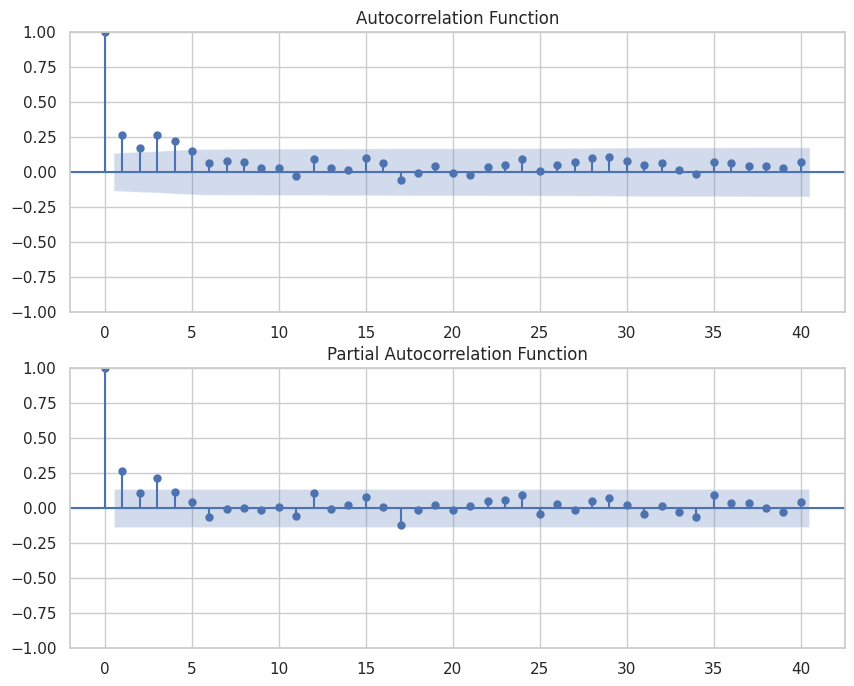

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

# ACF plot
plot_acf(merged_data['Quantity'], ax=ax[0], lags=40)
ax[0].set_title('Autocorrelation Function')

# PACF plot
plot_pacf(merged_data['Quantity'], ax=ax[1], lags=40)
ax[1].set_title('Partial Autocorrelation Function')

plt.show()

# **Determined parameters**

Value of D is 0, as sales data quantity is stationary

Values of P and Q are 1, because the PACF plot cuts off after lag 1 and the ACF plot shows a significant spike at lag 1, followed by smaller spikes that die off quickly

# **Models**

In [29]:
train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.1)
validation_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size + test_size]
validation = df[train_size + test_size:]

exog_columns = ['Clicks', 'Impressions','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
exog_train = train[exog_columns]
exog_test = test[exog_columns]
exog_validation = validation[exog_columns]
print('Train :', len(train))
print('Test :', len(test))
print('Validation :', len(validation))

Train : 169
Test : 21
Validation : 22


In [30]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def evaluate_model(model, train, test, validation, feature='Quantity'):
    model_fit = model.fit()
    test_predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    validation_predictions = model_fit.predict(start=len(train) + len(test), end=len(train) + len(test) + len(validation) - 1, dynamic=False)

    # Plot the results
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train[feature], label='Train Actual')
    plt.plot(test.index, test[feature], label='Test Actual')
    plt.plot(test.index, test_predictions, label='Test Predictions')
    plt.plot(validation.index, validation[feature], label='Validation Actual')
    plt.plot(validation.index, validation_predictions, label='Validation Predictions')
    plt.title(f'Training vs Validation vs Test')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()


    test_mae = mean_absolute_error(test[feature], test_predictions).round(2)
    test_rmse = np.sqrt(mean_squared_error(test[feature], test_predictions)).round(2)
    test_mape = mean_absolute_percentage_error(test[feature], test_predictions).round(2)
    test_r2 = r2_score(test[feature], test_predictions).round(2)
    test_adj_r2 = adjusted_r2(test_r2, len(test), model_fit.df_model).round(2)

    validation_mae = mean_absolute_error(validation[feature], validation_predictions).round(2)
    validation_rmse = np.sqrt(mean_squared_error(validation[feature], validation_predictions)).round(2)
    validation_mape = mean_absolute_percentage_error(validation[feature], validation_predictions).round(2)
    validation_r2 = r2_score(validation[feature], validation_predictions).round(2)
    validation_adj_r2 = adjusted_r2(validation_r2, len(validation), model_fit.df_model).round(2)

    return {
        'test': {'mae': test_mae, 'rmse': test_rmse, 'mape': test_mape, 'r2': test_r2, 'adj_r2': test_adj_r2, 'predictions': test_predictions},
        'validation': {'mae': validation_mae, 'rmse': validation_rmse, 'mape': validation_mape, 'r2': validation_r2, 'adj_r2': validation_adj_r2, 'predictions': validation_predictions}
    }

def evaluate_model_exog(model, train, test, validation, exog_test=None, exog_validation=None):

    # Generate predictions for the validation set
    validation_predictions = model.get_forecast(steps=len(validation), exog=exog_validation).predicted_mean

    # Generate predictions for the test set
    test_predictions = model.get_forecast(steps=len(test), exog=exog_test).predicted_mean

    # Plot the results
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train['Quantity'], label='Train', color='blue')
    plt.plot(validation.index, validation['Quantity'], label='Validation', color='orange')
    plt.plot(test.index, test['Quantity'], label='Test', color='green')
    plt.plot(validation.index, validation_predictions, label='Validation Predictions', color='red')
    plt.plot(test.index, test_predictions, label='Test Predictions', color='purple')
    plt.legend()
    plt.title(f' Validation vs Test')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()

    test_mae = mean_absolute_error(test['Quantity'], test_predictions).round(2)
    test_rmse = np.sqrt(mean_squared_error(test['Quantity'], test_predictions)).round(2)
    test_mape = mean_absolute_percentage_error(test['Quantity'], test_predictions).round(2)
    test_r2 = r2_score(test['Quantity'], test_predictions).round(2)
    test_adj_r2 = adjusted_r2(test_r2, len(test), exog_validation.shape[1]).round(2)

    validation_mae = mean_absolute_error(validation['Quantity'], validation_predictions).round(2)
    validation_rmse = np.sqrt(mean_squared_error(validation['Quantity'], validation_predictions)).round(2)
    validation_mape = mean_absolute_percentage_error(validation['Quantity'], validation_predictions).round(2)
    validation_r2 = r2_score(validation['Quantity'], validation_predictions).round(2)
    validation_adj_r2 = adjusted_r2(validation_r2, len(validation), exog_validation.shape[1]).round(2)

    return {
        'test': {'mae': test_mae, 'rmse': test_rmse, 'mape': test_mape, 'r2': test_r2, 'adj_r2': test_adj_r2, 'predictions': test_predictions},
        'validation': {'mae': validation_mae, 'rmse': validation_rmse, 'mape': validation_mape, 'r2': validation_r2, 'adj_r2': validation_adj_r2, 'predictions': validation_predictions}
    }


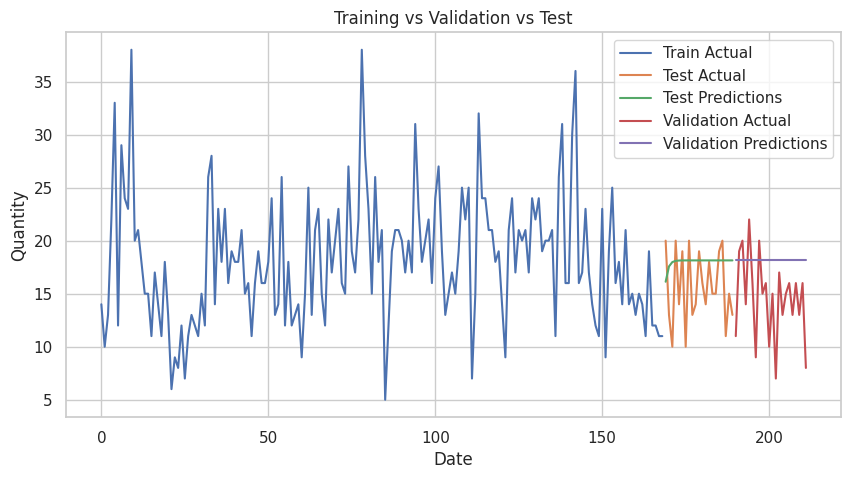

In [31]:
# AR(1) Model
ar_model = ARIMA(train['Quantity'], order=(1, 0, 0))
ar_results = evaluate_model(ar_model, train, test, validation)

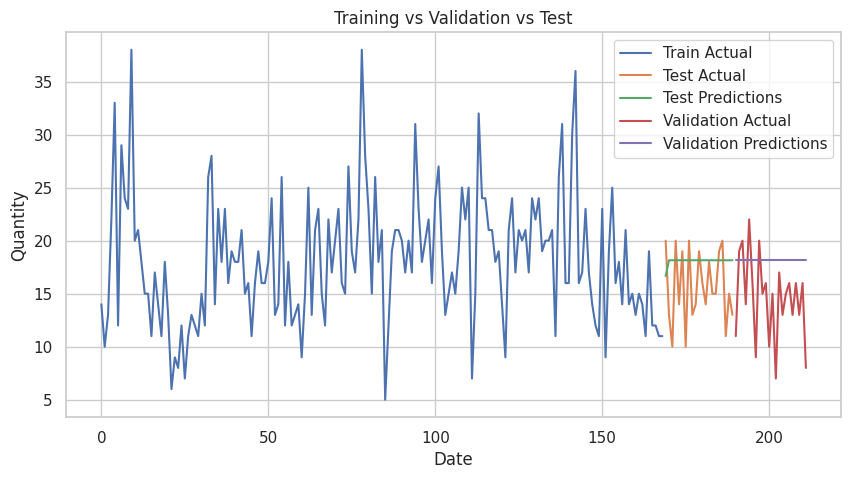

In [32]:
# MA(1) Model
ma_model = ARIMA(train['Quantity'], order=(0, 0, 1))
ma_results = evaluate_model(ma_model, train, test, validation)

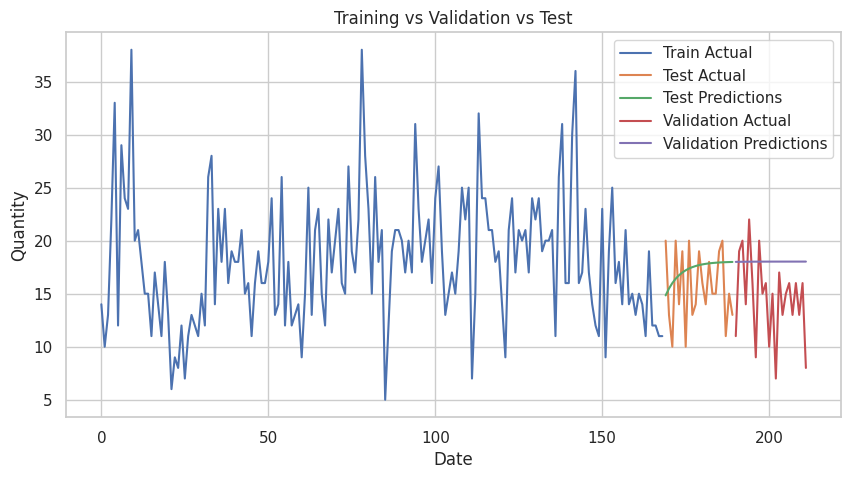

In [33]:
# ARIMA(1,0,1) Model
arima_model = ARIMA(train['Quantity'], order=(1, 0, 1))
arima_results = evaluate_model(arima_model, train, test, validation)

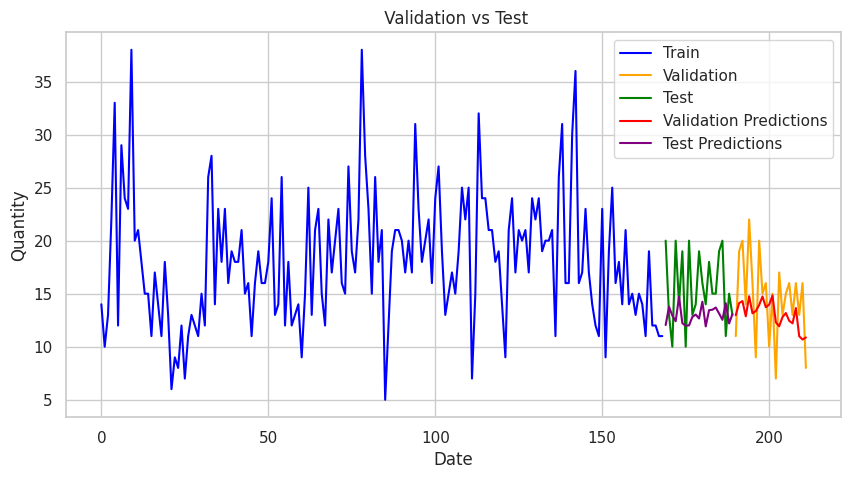

In [34]:
# ARIMAX (1,0,1)
arimax_model = ARIMA(train['Quantity'], order=(1, 0, 1), exog=exog_train).fit()
arimax_results = evaluate_model_exog(arimax_model, train, test, validation, exog_test, exog_validation)

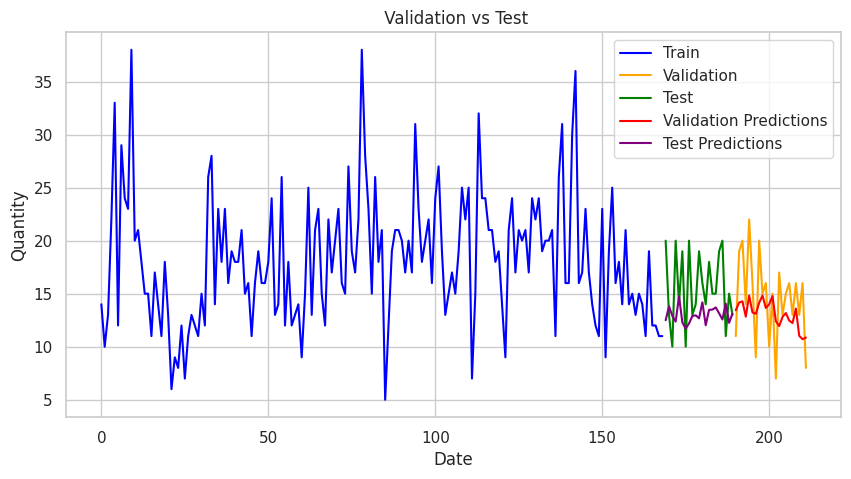

In [35]:
# SARIMAX(1,0,1)(1,0,1,12)
sarimax_model = SARIMAX(train['Quantity'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12), exog=exog_train).fit()
sarimax_results = evaluate_model_exog(sarimax_model, train, test, validation, exog_test, exog_validation)

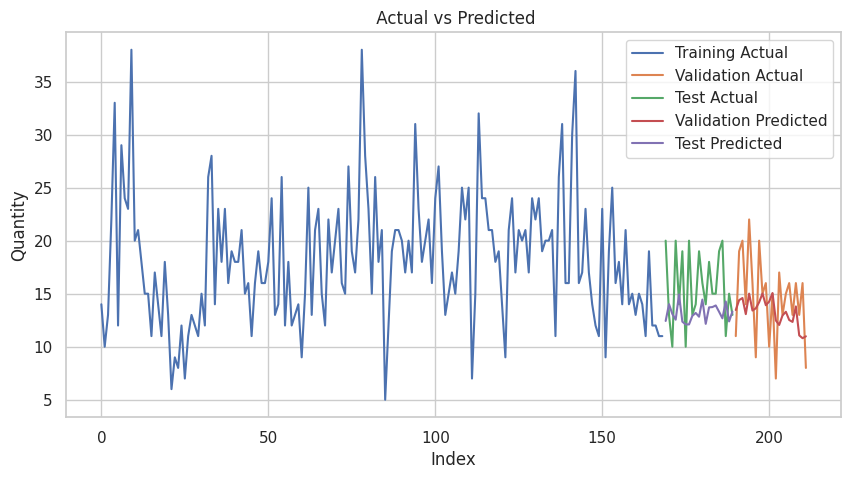

In [36]:
# Multivariate Linear Regression
# Features for multivariate regression
features = ['Clicks','Impressions','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Standardize the features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])
validation_scaled = scaler.transform(validation[features])

# Multivariate Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(train_scaled, train['Quantity'])

# Predictions
lr_test_predictions = lr_model.predict(test_scaled)
lr_validation_predictions = lr_model.predict(validation_scaled)

# Plot predictions vs actuals for all sets
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Quantity'], label='Training Actual')
plt.plot(validation.index, validation['Quantity'], label='Validation Actual')
plt.plot(test.index, test['Quantity'], label='Test Actual')
plt.plot(validation.index, lr_validation_predictions, label='Validation Predicted')
plt.plot(test.index, lr_test_predictions, label='Test Predicted')
plt.title(f' Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()
# Evaluation for Multivariate Linear Regression
lr_test_mae = mean_absolute_error(test['Quantity'], lr_test_predictions).round(2)
lr_test_rmse = np.sqrt(mean_squared_error(test['Quantity'], lr_test_predictions)).round(2)
lr_test_mape = mean_absolute_percentage_error(test['Quantity'], lr_test_predictions).round(2)
lr_test_r2 = r2_score(test['Quantity'], lr_test_predictions).round(2)
lr_test_adj_r2 = adjusted_r2(lr_test_r2, len(test), len(features)).round(2)

lr_validation_mae = mean_absolute_error(validation['Quantity'], lr_validation_predictions).round(2)
lr_validation_rmse = np.sqrt(mean_squared_error(validation['Quantity'], lr_validation_predictions)).round(2)
lr_validation_mape = mean_absolute_percentage_error(validation['Quantity'], lr_validation_predictions).round(2)
lr_validation_r2 = r2_score(validation['Quantity'], lr_validation_predictions).round(2)
lr_validation_adj_r2 = adjusted_r2(lr_validation_r2, len(validation), len(features)).round(2)

lr_results = {
    'test': {'mae': lr_test_mae, 'rmse': lr_test_rmse, 'mape': lr_test_mape, 'r2': lr_test_r2, 'adj_r2': lr_test_adj_r2, 'predictions': lr_test_predictions},
    'validation': {'mae': lr_validation_mae, 'rmse': lr_validation_rmse, 'mape': lr_validation_mape, 'r2': lr_validation_r2, 'adj_r2': lr_validation_adj_r2, 'predictions': lr_validation_predictions}
}


In [37]:
# Collecting results
results = {
    'Model': ['AR', 'MA', 'ARIMA', 'ARIMAX', 'SARIMAX', 'Multivariate Linear Regression'],
    'Test MAE': [ar_results['test']['mae'], ma_results['test']['mae'], arima_results['test']['mae'], arimax_results['test']['mae'], sarimax_results['test']['mae'], lr_results['test']['mae']],
    'Test RMSE': [ar_results['test']['rmse'], ma_results['test']['rmse'], arima_results['test']['rmse'], arimax_results['test']['rmse'], sarimax_results['test']['rmse'], lr_results['test']['rmse']],
    'Test MAPE': [ar_results['test']['mape'], ma_results['test']['mape'], arima_results['test']['mape'], arimax_results['test']['mape'], sarimax_results['test']['mape'], lr_results['test']['mape']],
    'Test R^2': [ar_results['test']['r2'], ma_results['test']['r2'], arima_results['test']['r2'], arimax_results['test']['r2'], sarimax_results['test']['r2'], lr_results['test']['r2']],
    'Test Adj R^2': [ar_results['test']['adj_r2'], ma_results['test']['adj_r2'], arima_results['test']['adj_r2'], arimax_results['test']['adj_r2'], sarimax_results['test']['adj_r2'], lr_results['test']['adj_r2']],
    'Validation MAE': [ar_results['validation']['mae'], ma_results['validation']['mae'], arima_results['validation']['mae'], arimax_results['validation']['mae'], sarimax_results['validation']['mae'], lr_results['validation']['mae']],
    'Validation RMSE': [ar_results['validation']['rmse'], ma_results['validation']['rmse'], arima_results['validation']['rmse'], arimax_results['validation']['rmse'], sarimax_results['validation']['rmse'], lr_results['validation']['rmse']],
    'Validation MAPE': [ar_results['validation']['mape'], ma_results['validation']['mape'], arima_results['validation']['mape'], arimax_results['validation']['mape'], sarimax_results['validation']['mape'], lr_results['validation']['mape']],
    'Validation R^2': [ar_results['validation']['r2'], ma_results['validation']['r2'], arima_results['validation']['r2'], arimax_results['validation']['r2'], sarimax_results['validation']['r2'], lr_results['validation']['r2']],
    'Validation Adj R^2': [ar_results['validation']['adj_r2'], ma_results['validation']['adj_r2'], arima_results['validation']['adj_r2'], arimax_results['validation']['adj_r2'], sarimax_results['validation']['adj_r2'], lr_results['validation']['adj_r2']]
}

results_df = pd.DataFrame(results)
print(results_df)


                            Model  Test MAE  Test RMSE  Test MAPE  Test R^2  \
0                              AR      3.54       4.19      27.00     -0.59   
1                              MA      3.55       4.22      27.20     -0.62   
2                           ARIMA      3.37       3.84      24.80     -0.34   
3                          ARIMAX      3.56       4.50      21.00     -0.84   
4                         SARIMAX      3.51       4.43      20.64     -0.78   
5  Multivariate Linear Regression      3.48       4.39      20.65     -0.75   

   Test Adj R^2  Validation MAE  Validation RMSE  Validation MAPE  \
0         -0.87            4.32             5.22            39.04   
1         -0.91            4.32             5.23            39.12   
2         -0.68            4.24             5.15            38.39   
3         -2.35            3.19             3.79             1.13   
4         -2.24            3.19             3.77             1.22   
5         -2.18            3.11 